In [1]:
# common imports
import numpy as np
import pandas as pd
import os, cv2, joblib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# global variables
global ROWS, COLUMNS, CHANNELS, IS_CANNY
CLASSES = {0: 'cat', 1: 'dog'}

# display setup
sns.set(style="whitegrid")  # for plots

# Preface
* Dogs vs. Cats is a dataset containing 25,000 samples.
* Each sample is a colored image (JPEG file) of a dog or a cat. The image sizes vary, so they need to be scaled to the same size.
* The data contains two labels (mentioned in each image file's name), making this a **binary classification** problem.
In other words, this is a **supervised learning** task.
* The model will be trained using all available data and run without learning anymore. This method is named **offline/batch learning**.
* Main objective: Find the best algorithm and model parameters that classify the unused images correctly.

# 1. Getting the Data

In [2]:
path = r"dogs-vs-cats\train/"

images = [path + i for i in os.listdir(path)]
# listdir returns a list with the file names in the given directory

In [3]:
def load_dogs_vs_cats(image_dir):
    images_lst = [image_dir + i for i in os.listdir(image_dir)]
    # listdir returns a list with the file names in the given directory
    y = []
    path = []
    for i, image_path in enumerate(images_lst):
        path.append(image_path)
        if '/dog' in image_path:
            y.append(1)
        elif '/cat' in image_path:
            y.append(0)
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y.append(image_path.split('/')[-1].split('.')[0])
    return pd.DataFrame({"path": path, "label": y})

In [4]:
df = load_dogs_vs_cats(path)

In [5]:
df.head()

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0
3,dogs-vs-cats\train/cat.100.jpg,0
4,dogs-vs-cats\train/cat.1000.jpg,0


In [6]:
df.isna().sum().sum()

0

In [7]:
df['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [8]:
# use groupby to locate instances for each label
label_groups = df.groupby('label')

In [9]:
# 3 cat image samples
sample0 = label_groups.get_group(0)[:3]
sample0

,path,label
0,dogs-vs-cats\train/cat.0.jpg,0
1,dogs-vs-cats\train/cat.1.jpg,0
2,dogs-vs-cats\train/cat.10.jpg,0


In [10]:
# 3 dog image samples
sample1 = label_groups.get_group(1)[:3]
sample1

,path,label
12500,dogs-vs-cats\train/dog.0.jpg,1
12501,dogs-vs-cats\train/dog.1.jpg,1
12502,dogs-vs-cats\train/dog.10.jpg,1


In [11]:
# combine cat and dog samples as one DataFrame
sample_images = pd.concat([sample0, sample1], ignore_index=True)

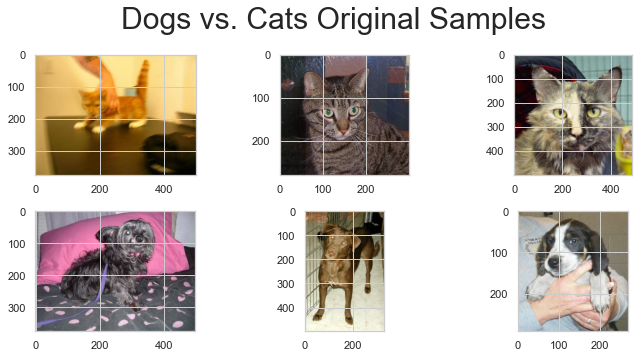

In [12]:
fig = plt.figure(figsize=(10, 7))

for i in range(len(sample_images)):
    plt.subplot(330 + i + 1)
    filename = sample_images['path'][i]
    image = cv2.imread(filename)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
fig.suptitle("Dogs vs. Cats Original Samples", size=30)
plt.tight_layout()
plt.show()

> Initial Observations:
>> * The dogs and cats are in different angles. Some are cropped in a way that only the face is seen,
>> others of the whole body.
>> * The photos may also include a person or surrounding objects (i.e. in the bottom right image the
> dog is held by a person).
>> The photos could also be blurry (i.e. in the top left photo it looks like the camera was slightly
>> moved while taking the photo).
>> * There are various image sizes.
>> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
>> * The images are in color, meaning the number of pixels chosen for the width and height will be multiplied by 3.
>> This should be taken into account since it adds a substantial amount of features, as opposing to using grayscale images.
>
> The following functions will read the data, and turn it into a DataFrame.
> When implementing these functions, I took into account that rescaling the images and loading new data could be needed
> further on. (Necessary tweaks implemented in the code according to these measures).
>
> Note: The default rescaled size of the images is 64x64x3. This will likely change later on.

> ### Splitting the Data:
>> Before further analysis let's split the data into a training set and a testing set.
>> This will ensure avoidance of bias that could occur from learning the data as a whole.

The training and testing data should be representative of both classes.
I noticed that the number of samples for dogs and cats are equal and decided a stratified
split is the optimal choice.
Although regular random sampling would have split the data nearly equally, there would
have been more bias towards one of the classes.

In [13]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['label']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [14]:
# make sure that class distribution is equal
strat_test_set['label'].value_counts() / len(strat_test_set)

1    0.5
0    0.5
Name: label, dtype: float64

In [15]:
# DataFrame shape (rows, columns)
print("Training Set:", strat_train_set.shape)
print("Test Set:", strat_test_set.shape)

Training Set: (20000, 2)
Test Set: (5000, 2)


# 2. Understanding and Visualizing the Data
> ##### *The motivation for this section is to gain more insights.*

In [16]:
# deep copy of the training set
df2 = strat_train_set.copy()

In [17]:
df2.head(2)

,path,label
20022,dogs-vs-cats\train/dog.5518.jpg,1
4993,dogs-vs-cats\train/cat.3241.jpg,0


In [18]:
def image_shape(image_path):
    return cv2.imread(image_path).shape


def load_data_shapes(image_file_names):
    shapes = []
    for i, image_file in enumerate(image_file_names):
        shapes.append(image_shape(image_file))
    return shapes

In [19]:
# image_shapes = load_data_shapes(strat_train_set['path'])
# joblib.dump(image_shapes, "dogs-vs-cats/image_shapes.pkl")

In [20]:
image_shapes = joblib.load(r"dogs-vs-cats/image_shapes.pkl")

In [21]:
image_res_df = pd.DataFrame(image_shapes, columns=['height', 'width', 'n_channels'])
image_res_df.head(3)

,height,width,n_channels
0,138,129,3
1,374,500,3
2,438,349,3


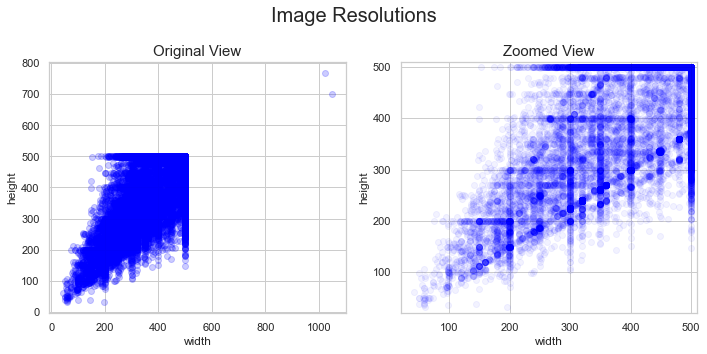

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.2)
ax1.set_title("Original View", size=15)
points = ax2.scatter(image_res_df.width, image_res_df.height, color='blue', alpha=0.05)
ax1.set_xlabel("width")
ax1.set_ylabel("height")
ax2.set_xlim(xmin=20, xmax=510)
ax2.set_ylim(ymin=20, ymax=510)
ax2.set_title("Zoomed View", size=15)
ax2.set_xlabel("width")
ax2.set_ylabel("height")
fig.suptitle("Image Resolutions", size=20)
plt.tight_layout()
plt.show()

In [23]:
image_res_df["height"].min()

32

In [24]:
image_res_df["width"].min()

42

> Observations:
> * Most image resolutions are less than 500x500. There is also a fair amount around 400x400,
> 300x300, and 200x200.

## Exploring Pre-processing Implementations
>
> The pixels represent the features in the data. The larger the size is, the higher the complexity.
Additionally, processing the images with color results in 3 times more features than in grayscale.
>
> In this next part, I will evaluate several pre-processing options.
>
> #### Incremental Sizing:
> In this approach, the images are rescaled to a small size, gradually increasing.
>> Sizes:
1. 30x30
2. 40x40
3. 50x50

#### Why is resizing necessary?
In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.


> Although actual model training will be later on, I will train simple Logistic Regression baseline models
> to easily compare the performance on 3 different transformations (in order from highest to lowest complexity):
>> Transformations:
1. Color
2. Grayscale
3. Canny Edge Detection

#### What is Canny Edge Detection?

Note: The algorithm is based on grayscale images.

> After many attempts, the color images increased complexity significantly! I was unable to run simple
> transformations on the data. Since it seems unlikely that the color has much significance to the
> images (i.e. there are people and objects other than the dogs and cats), I decided to switch to
> grayscale.
>
> Note: The global variables (instantiated below the imports) have been set to these values.

### Pre-processing Implementations:
1. Use grayscale images (has one channel so there are fewer features).
2. Dimensionality reduction using PCA (the grayscale images have 40,000 features!).
3. K-Means for image segmentation.
4. Dimensionality reduction using K-Means.

**To help determine which pre-processing is the best, I will train a couple baseline models on each
of them and compare the results.**

> Why is resizing necessary?
>
> In order to use the data for ML algorithms, all images need to be processed into an array containing the same pixel values.
> The following functions do just that:
>
> Note: If needed, the code is implemented with an option to process images with color.

In [25]:
# set global variables
def set_params(n_rows, n_cols, n_channels, is_canny):
    global ROWS, COLUMNS, CHANNELS, IS_CANNY
    ROWS = n_rows
    COLUMNS = n_cols
    CHANNELS = n_channels
    IS_CANNY = is_canny


def read_resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if CHANNELS == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if IS_CANNY:
            img = cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)
            img = cv2.Canny(img, 100, 200)
            return img
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)


def prep_data(images, n_rows, n_cols, n_channels, is_canny):
    set_params(n_rows, n_cols, n_channels, is_canny) # set global variables with inserted values
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1), dtype=np.uint8)
    #    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        #        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y.flatten()

s = strat_train_set[:2]
X, y = prep_data(s.path, 30, 30, 1, True)

plt.imshow(np.array(X[1]).reshape(30,30,1))

> #### How to choose rescale size:
* Start rescaling from 28x28, trying both grayscale and color.
* Train Logistic Regression baseline models on various data transformations.
* Evaluate the accuracy score for each of the model predictions.
* Choose the optimal scale and colors.

In [26]:
# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))


> #### 28x28 Observations:
* Although at first it seemed like color was going to obtain the highest score,
cross-validation showed that canny is just as good as color!
(I would even consider canny as much better than color, since canny has fewer features).
* Grayscale underperformed both color and canny.

> #### 64x64 Observations:
* 64x64 color was worse than 28x28 color. Although the model fit the training set better, cross-validation showed
a decrease in performance.
* 64x64 grayscale fit the training data better compared to 28x28 grayscale, with a minimal decrease in
cross-validation accuracy.

In [27]:
img1_before = strat_train_set['path'][0:1].iloc[0]
img2_before = strat_train_set['path'][1:2].iloc[0]

def plot_before_after(img1, img2):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(2, 2, 1)
    image = cv2.imread(img1_before)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.title('Before', size=15)
    fig.add_subplot(2, 2, 3)
    plt.imshow(img1.reshape((ROWS, COLUMNS, CHANNELS)), cmap='gray')
    plt.grid(False)
    plt.title('After', size=15)
    fig.add_subplot(2, 2, 2)
    image = cv2.imread(img2_before)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.grid(False)
    plt.title('Before', size=15)
    fig.add_subplot(2, 2, 4)
    plt.imshow(img2.reshape((ROWS, COLUMNS, CHANNELS)), cmap='gray')
    plt.grid(False)
    plt.title('After', size=15)
    fig.suptitle("Dogs vs. Cats Resized Samples", size=30)
    plt.tight_layout()
    plt.show()

> #### 30x30x3 Color

Data shape: (20000, 2700)
Target shape: (20000,)


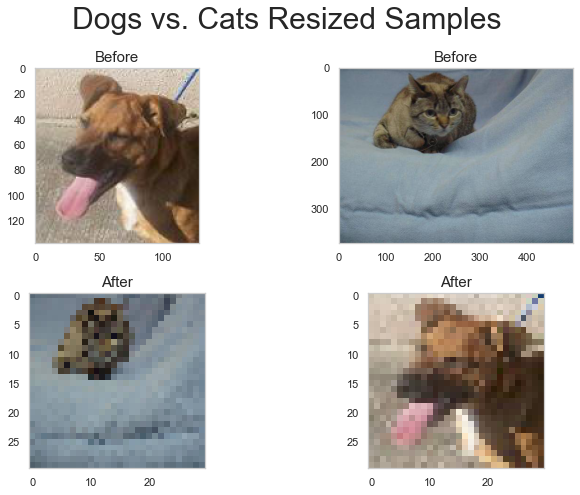

In [28]:
# X_30, y_30 = prep_data(strat_train_set["path"], 30, 30, 3, is_canny=False)
# joblib.dump(X_30, "dogs-vs-cats/data/X_30.pkl")
# joblib.dump(y_30, "dogs-vs-cats/data/y_30.pkl")

X_30 = joblib.load(r"dogs-vs-cats/data/X_30.pkl")
y_30 = joblib.load(r"dogs-vs-cats/data/y_30.pkl")
set_params(30, 30, 3, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_30.shape)
print("Target shape:", y_30.shape)

plot_before_after(X_30[1], X_30[0])

X_30 = StandardScaler().fit_transform(X_30)

In [29]:
# log_reg_30 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30.fit(X_30, y_30)
# joblib.dump(log_reg_30, "dogs-vs-cats/models/log_reg_30.pkl")
log_reg_30 = joblib.load(r"dogs-vs-cats/models/log_reg_30.pkl")

In [30]:
# log_reg_30_pred = log_reg_30.predict(X_30)
# joblib.dump(log_reg_30_pred, "dogs-vs-cats/pred/log_reg_30_pred.pkl")
log_reg_30_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30_pred.pkl")
metrics.accuracy_score(y_30, log_reg_30_pred)

0.68855

In [31]:
# log_reg_30_scores = cross_val_score(log_reg_30, X_30, y_30, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30_scores, "dogs-vs-cats/scores/log_reg_30_scores.pkl")
log_reg_30_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30_scores.pkl")
display_scores(log_reg_30_scores)

Scores: [0.592  0.5962 0.6004 0.5972]
Mean: 0.59645
Standard Deviation: 0.003


> #### 30x30 Grayscale

Data shape: (20000, 900)
Target shape: (20000,)


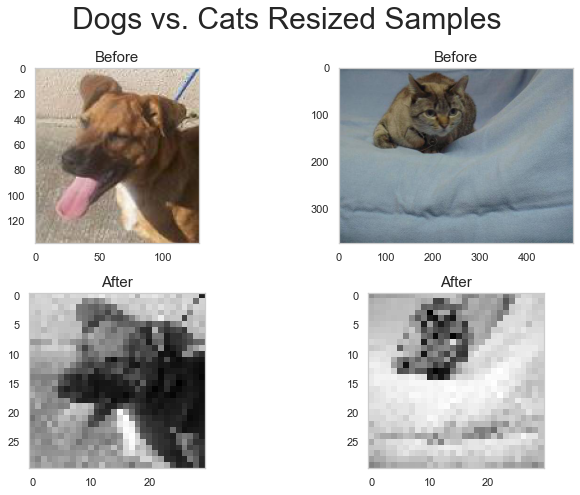

In [32]:
# X_30g, y_30g = prep_data(strat_train_set["path"], 30, 30, 1, is_canny=False)
# joblib.dump(X_30g, "dogs-vs-cats/data/X_30g.pkl")
# joblib.dump(y_30g, "dogs-vs-cats/data/y_30g.pkl")

X_30g = joblib.load(r"dogs-vs-cats/data/X_30g.pkl")
y_30g = joblib.load(r"dogs-vs-cats/data/y_30g.pkl")
set_params(30, 30, 1, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_30g.shape)
print("Target shape:", y_30g.shape)

plot_before_after(X_30g[0], X_30g[1])

X_30g = StandardScaler().fit_transform(X_30g)

In [33]:
# log_reg_30g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30g.fit(X_30g, y_30g)
# joblib.dump(log_reg_30g, "dogs-vs-cats/models/log_reg_30g.pkl")
log_reg_30g = joblib.load(r"dogs-vs-cats/models/log_reg_30g.pkl")

In [34]:
# log_reg_30g_pred = log_reg_30g.predict(X_30g)
# joblib.dump(log_reg_30g_pred, "dogs-vs-cats/pred/log_reg_30g_pred.pkl")
log_reg_30g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30g_pred.pkl")
metrics.accuracy_score(y_30g, log_reg_30g_pred)

0.6097

In [35]:
# log_reg_30g_scores = cross_val_score(log_reg_30g, X_30g, y_30g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30g_scores, "dogs-vs-cats/scores/log_reg_30g_scores.pkl")
log_reg_30g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30g_scores.pkl")
display_scores(log_reg_30g_scores)

Scores: [0.5456 0.5286 0.5462 0.551 ]
Mean: 0.54285
Standard Deviation: 0.00849


> #### 30x30 Canny

Data shape: (20000, 900)
Target shape: (20000,)


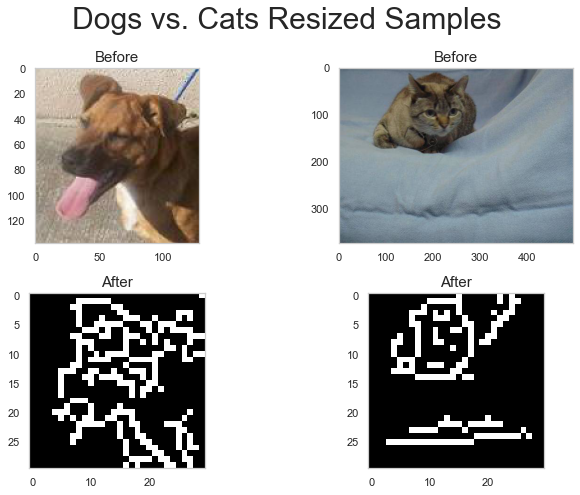

In [36]:
# X_30C, y_30C = prep_data(strat_train_set["path"], 30, 30, 1, is_canny=True)
# joblib.dump(X_30C, "dogs-vs-cats/data/X_30C.pkl")
# joblib.dump(y_30C, "dogs-vs-cats/data/y_30C.pkl")

X_30C = joblib.load(r"dogs-vs-cats/data/X_30C.pkl")
y_30C = joblib.load(r"dogs-vs-cats/data/y_30C.pkl")
set_params(30, 30, 1, is_canny=True)

# data shape (rows, columns)
print("Data shape:", X_30C.shape)
print("Target shape:", y_30C.shape)

plot_before_after(X_30C[0], X_30C[1])

X_30C = StandardScaler().fit_transform(X_30C)

In [37]:
# log_reg_30C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_30C.fit(X_30C, y_30C)
# joblib.dump(log_reg_30C, "dogs-vs-cats/models/log_reg_30C.pkl")
log_reg_30C = joblib.load(r"dogs-vs-cats/models/log_reg_30C.pkl")

In [38]:
# log_reg_30C_pred = log_reg_30C.predict(X_30C)
# joblib.dump(log_reg_30C_pred, "dogs-vs-cats/pred/log_reg_30C_pred.pkl")
log_reg_30C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_30C_pred.pkl")
metrics.accuracy_score(y_30C, log_reg_30C_pred)

0.65105

In [39]:
# log_reg_30C_scores = cross_val_score(log_reg_30C, X_30C, y_30C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_30C_scores, "dogs-vs-cats/scores/log_reg_30C_scores.pkl")
log_reg_30C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_30C_scores.pkl")
display_scores(log_reg_30C_scores)

Scores: [0.5924 0.595  0.5964 0.5816]
Mean: 0.59135
Standard Deviation: 0.00581


> #### 40x40x3 Color

Data shape: (20000, 4800)
Target shape: (20000,)


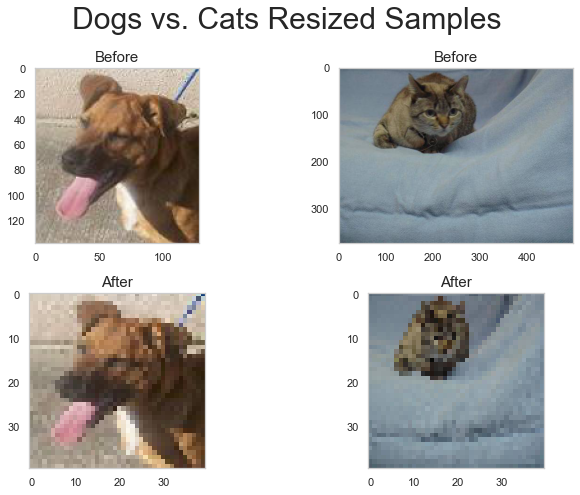

In [40]:
# X_40, y_40 = prep_data(strat_train_set["path"], 40, 40, 3, is_canny=False)
# joblib.dump(X_40, "dogs-vs-cats/data/X_40.pkl")
# joblib.dump(y_40, "dogs-vs-cats/data/y_40.pkl")

X_40 = joblib.load(r"dogs-vs-cats/data/X_40.pkl")
y_40 = joblib.load(r"dogs-vs-cats/data/y_40.pkl")
set_params(40, 40, 3, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_40.shape)
print("Target shape:", y_40.shape)

plot_before_after(X_40[0], X_40[1])

X_40 = StandardScaler().fit_transform(X_40)

In [41]:
# log_reg_40 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40.fit(X_40, y_40)
# joblib.dump(log_reg_40, "dogs-vs-cats/models/log_reg_40.pkl")
log_reg_40 = joblib.load(r"dogs-vs-cats/models/log_reg_40.pkl")

In [42]:
# log_reg_40_pred = log_reg_40.predict(X_40)
# joblib.dump(log_reg_40_pred, "dogs-vs-cats/pred/log_reg_40_pred.pkl")
log_reg_40_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40_pred.pkl")
metrics.accuracy_score(y_40, log_reg_40_pred)

0.69485

In [43]:
# log_reg_40_scores = cross_val_score(log_reg_40, X_40, y_40, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40_scores, "dogs-vs-cats/scores/log_reg_40_scores.pkl")
log_reg_40_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40_scores.pkl")
display_scores(log_reg_40_scores)

Scores: [0.5776 0.5774 0.5798 0.5762]
Mean: 0.57775
Standard Deviation: 0.0013


> #### 40x40 Grayscale

Data shape: (20000, 1600)
Target shape: (20000,)


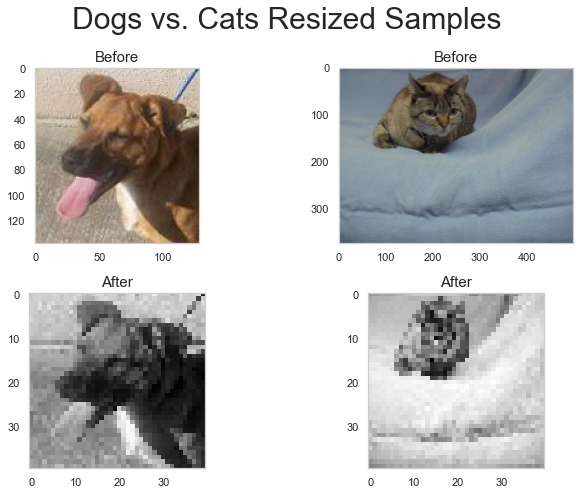

In [44]:
# X_40g, y_40g = prep_data(strat_train_set["path"], 40, 40, 1, is_canny=False)
# joblib.dump(X_40g, "dogs-vs-cats/data/X_40g.pkl")
# joblib.dump(y_40g, "dogs-vs-cats/data/y_40g.pkl")

X_40g = joblib.load(r"dogs-vs-cats/data/X_40g.pkl")
y_40g = joblib.load(r"dogs-vs-cats/data/y_40g.pkl")
set_params(40, 40, 1, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_40g.shape)
print("Target shape:", y_40g.shape)

plot_before_after(X_40g[0], X_40g[1])

X_40g = StandardScaler().fit_transform(X_40g)

In [45]:
# log_reg_40g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40g.fit(X_40g, y_40g)
# joblib.dump(log_reg_40g, "dogs-vs-cats/models/log_reg_40g.pkl")
log_reg_40g = joblib.load(r"dogs-vs-cats/models/log_reg_40g.pkl")

In [46]:
# log_reg_40g_pred = log_reg_40g.predict(X_40g)
# joblib.dump(log_reg_40g_pred, "dogs-vs-cats/pred/log_reg_40g_pred.pkl")
log_reg_40g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40g_pred.pkl")
metrics.accuracy_score(y_40g, log_reg_40g_pred)

0.63075

In [47]:
# log_reg_40g_scores = cross_val_score(log_reg_40g, X_40g, y_40g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40g_scores, "dogs-vs-cats/scores/log_reg_40g_scores.pkl")
log_reg_40g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40g_scores.pkl")
display_scores(log_reg_40g_scores)

Scores: [0.5308 0.5226 0.5256 0.5284]
Mean: 0.52685
Standard Deviation: 0.00307


> #### 40x40 Canny

Data shape: (20000, 1600)
Target shape: (20000,)


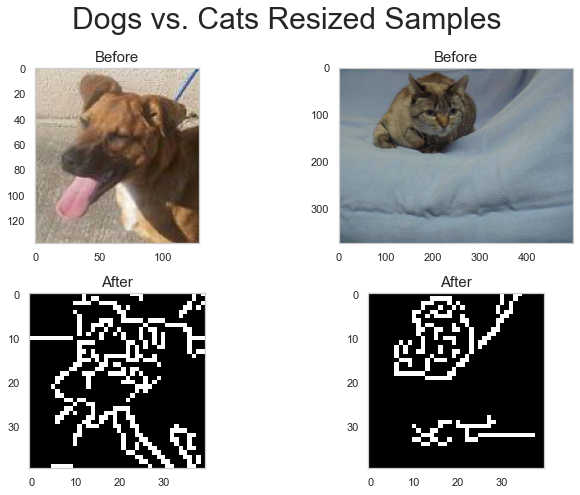

In [48]:
# X_40C, y_40C = prep_data(strat_train_set["path"], 40, 40, 1, is_canny=True)
# joblib.dump(X_40C, "dogs-vs-cats/data/X_40C.pkl")
# joblib.dump(y_40C, "dogs-vs-cats/data/y_40C.pkl")

X_40C = joblib.load(r"dogs-vs-cats/data/X_40C.pkl")
y_40C = joblib.load(r"dogs-vs-cats/data/y_40C.pkl")
set_params(40, 40, 1, is_canny=True)

# data shape (rows, columns)
print("Data shape:", X_40C.shape)
print("Target shape:", y_40C.shape)

plot_before_after(X_40C[0], X_40C[1])

X_40C = StandardScaler().fit_transform(X_40C)

In [49]:
# log_reg_40C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_40C.fit(X_40C, y_40C)
# joblib.dump(log_reg_40C, "dogs-vs-cats/models/log_reg_40C.pkl")
log_reg_40C = joblib.load(r"dogs-vs-cats/models/log_reg_40C.pkl")

In [50]:
# log_reg_40C_pred = log_reg_40C.predict(X_40C)
# joblib.dump(log_reg_40C_pred, "dogs-vs-cats/pred/log_reg_40C_pred.pkl")
log_reg_40C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_40C_pred.pkl")
metrics.accuracy_score(y_40C, log_reg_40C_pred)

0.67395

In [51]:
# log_reg_40C_scores = cross_val_score(log_reg_40C, X_40C, y_40C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_40C_scores, "dogs-vs-cats/scores/log_reg_40C_scores.pkl")
log_reg_40C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_40C_scores.pkl")
display_scores(log_reg_40C_scores)

Scores: [0.58   0.5854 0.5892 0.5828]
Mean: 0.58435
Standard Deviation: 0.00339


> #### 50x50x3 Color

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data
Data shape: (20000, 7500)
Target shape: (20000,)


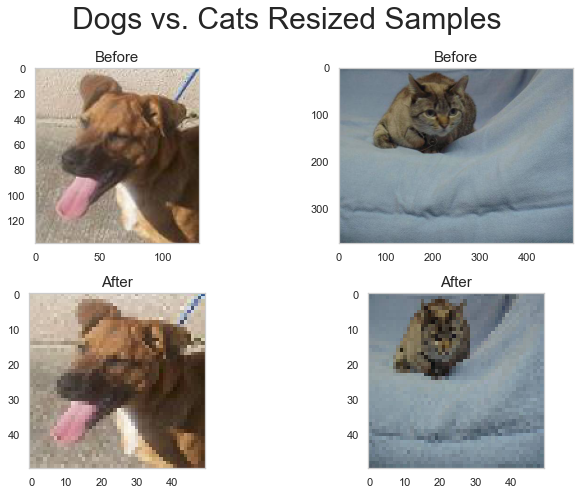

In [52]:
# X_50, y_50 = prep_data(strat_train_set["path"], 50, 50, 3, is_canny=False)
# joblib.dump(X_50, "dogs-vs-cats/data/X_50.pkl")
# joblib.dump(y_50, "dogs-vs-cats/data/y_50.pkl")

X_50 = joblib.load(r"dogs-vs-cats/data/X_50.pkl")
y_50 = joblib.load(r"dogs-vs-cats/data/y_50.pkl")
set_params(50, 50, 3, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_50.shape)
print("Target shape:", y_50.shape)

plot_before_after(X_50[0], X_50[1])

X_50 = StandardScaler().fit_transform(X_50)

In [53]:
# log_reg_50 = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50.fit(X_50, y_50)
# joblib.dump(log_reg_50, "dogs-vs-cats/models/log_reg_50.pkl")
log_reg_50 = joblib.load(r"dogs-vs-cats/models/log_reg_50.pkl")

['dogs-vs-cats/models/log_reg_50.pkl']

In [54]:
# log_reg_50_pred = log_reg_50.predict(X_50)
# joblib.dump(log_reg_50_pred, "dogs-vs-cats/pred/log_reg_50_pred.pkl")
log_reg_50_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50_pred.pkl")
metrics.accuracy_score(y_50, log_reg_50_pred)

0.7192

In [55]:
# log_reg_50_scores = cross_val_score(log_reg_50, X_50, y_50, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50_scores, "dogs-vs-cats/scores/log_reg_50_scores.pkl")
log_reg_50_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50_scores.pkl")
display_scores(log_reg_50_scores)

Scores: [0.5674 0.5666 0.5694 0.5742]
Mean: 0.5694
Standard Deviation: 0.00295


> #### 50x50 Grayscale

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data
Data shape: (20000, 2500)
Target shape: (20000,)


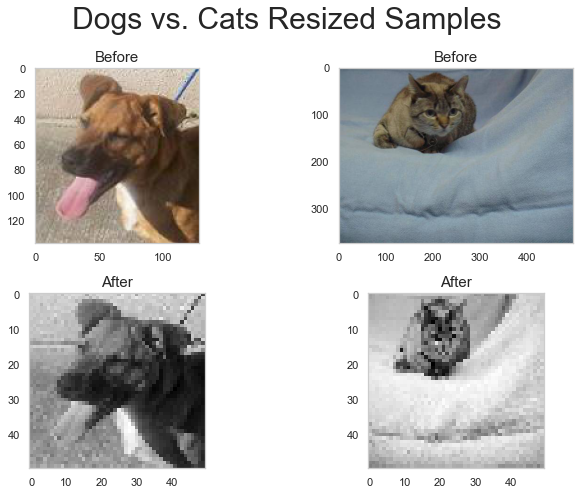

In [56]:
# X_50g, y_50g = prep_data(strat_train_set["path"], 50, 50, 1, is_canny=False)
# joblib.dump(X_50g, "dogs-vs-cats/data/X_50g.pkl")
# joblib.dump(y_50g, "dogs-vs-cats/data/y_50g.pkl")

X_50g = joblib.load(r"dogs-vs-cats/data/X_50g.pkl")
y_50g = joblib.load(r"dogs-vs-cats/data/y_50g.pkl")
set_params(50, 50, 1, is_canny=False)

# data shape (rows, columns)
print("Data shape:", X_50g.shape)
print("Target shape:", y_50g.shape)

plot_before_after(X_50g[0], X_50g[1])

X_50g = StandardScaler().fit_transform(X_50g)

In [57]:
# log_reg_50g = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50g.fit(X_50g, y_50g)
# joblib.dump(log_reg_50g, "dogs-vs-cats/models/log_reg_50g.pkl")
log_reg_50g = joblib.load(r"dogs-vs-cats/models/log_reg_50g.pkl")

['dogs-vs-cats/models/log_reg_50g.pkl']

In [58]:
# log_reg_50g_pred = log_reg_50g.predict(X_50g)
# joblib.dump(log_reg_50g_pred, "dogs-vs-cats/pred/log_reg_50g_pred.pkl")
log_reg_50g_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50g_pred.pkl")
metrics.accuracy_score(y_50g, log_reg_50g_pred)

0.66085

In [59]:
# log_reg_50g_scores = cross_val_score(log_reg_50g, X_50g, y_50g, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50g_scores, "dogs-vs-cats/scores/log_reg_50g_scores.pkl")
log_reg_50g_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50g_scores.pkl")
display_scores(log_reg_50g_scores)

Scores: [0.5278 0.5258 0.5222 0.5408]
Mean: 0.52915
Standard Deviation: 0.00702


> #### 50x50 Canny

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data
Data shape: (20000, 2500)
Target shape: (20000,)


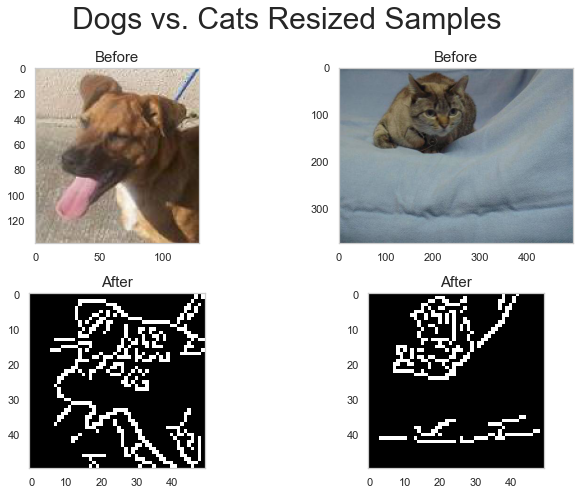

In [60]:
# X_50C, y_50C = prep_data(strat_train_set["path"], 50, 50, 1, is_canny=True)
# joblib.dump(X_50C, "dogs-vs-cats/data/X_50C.pkl")
# joblib.dump(y_50C, "dogs-vs-cats/data/y_50C.pkl")

X_50C = joblib.load(r"dogs-vs-cats/data/X_50C.pkl")
y_50C = joblib.load(r"dogs-vs-cats/data/y_50C.pkl")
set_params(50, 50, 1, is_canny=True)

# data shape (rows, columns)
print("Data shape:", X_50C.shape)
print("Target shape:", y_50C.shape)

plot_before_after(X_50C[0], X_50C[1])

X_50C = StandardScaler().fit_transform(X_50C)

In [61]:
# log_reg_50C = LogisticRegression(random_state=42, n_jobs=-1)
# log_reg_50C.fit(X_50C, y_50C)
# joblib.dump(log_reg_50C, "dogs-vs-cats/models/log_reg_50C.pkl")
log_reg_50C = joblib.load(r"dogs-vs-cats/models/log_reg_50C.pkl")

['dogs-vs-cats/models/log_reg_50C.pkl']

In [62]:
# log_reg_50C_pred = log_reg_50C.predict(X_50C)
# joblib.dump(log_reg_50C_pred, "dogs-vs-cats/pred/log_reg_50C_pred.pkl")
log_reg_50C_pred = joblib.load(r"dogs-vs-cats/pred/log_reg_50C_pred.pkl")
metrics.accuracy_score(y_50C, log_reg_50C_pred)

0.69355

In [63]:
# log_reg_50C_scores = cross_val_score(log_reg_50C, X_50C, y_50C, scoring="accuracy", cv=4)
# joblib.dump(log_reg_50C_scores, "dogs-vs-cats/scores/log_reg_50C_scores.pkl")
log_reg_50C_scores = joblib.load(r"dogs-vs-cats/scores/log_reg_50C_scores.pkl")
display_scores(log_reg_50C_scores)

Scores: [0.571  0.5692 0.5696 0.5574]
Mean: 0.5668
Standard Deviation: 0.00547


* As the size increases, the model fits the training set better (perhaps sometimes overfitting it).
However, cross-validation accuracy decreased, meaning that the models performed worse
on unseen data.
* Grayscale had the lowest accuracy in each scale.

The transformations have narrowed down to two options: 30x30 color and canny.

To help decide which is better, I'll train 2 additional simple baseline models:
KNN and Decision Tree Classifier.
The diverse algorithms should help decide which transformation is better.

> #### 30x30x3 Color: KNN, Decision Tree

In [64]:
knn_clf_30 = KNeighborsClassifier(n_jobs=-1)
knn_clf_30.fit(X_30, y_30)
joblib.dump(knn_clf_30, "dogs-vs-cats/models/knn_clf_30.pkl")
# knn_clf_30 = joblib.load(r"dogs-vs-cats/models/knn_clf_30.pkl")

tree_clf_30 = DecisionTreeClassifier(random_state=42)
tree_clf_30.fit(X_30, y_30)
joblib.dump(tree_clf_30, "dogs-vs-cats/models/tree_clf_30.pkl")
# tree_clf_30 = joblib.load(r"dogs-vs-cats/models/tree_clf_30.pkl")

['dogs-vs-cats/models/tree_clf_30.pkl']

In [65]:
knn_clf_30_pred = knn_clf_30.predict(X_30)
joblib.dump(knn_clf_30_pred, "dogs-vs-cats/pred/knn_clf_30_pred.pkl")
# knn_clf_30_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_30_pred.pkl")
print("KNN:", metrics.accuracy_score(y_30, knn_clf_30_pred))

tree_clf_30_pred = tree_clf_30.predict(X_30)
joblib.dump(tree_clf_30_pred, "dogs-vs-cats/pred/tree_clf_30_pred.pkl")
# tree_clf_30_pred = joblib.load(r"dogs-vs-cats/pred/tree_clf_30_pred.pkl")
print("Decision Tree:", metrics.accuracy_score(y_30, tree_clf_30_pred))

KNN: 0.69635
Decision Tree: 1.0


In [66]:
knn_clf_30_scores = cross_val_score(knn_clf_30, X_30, y_30, scoring="accuracy", cv=4)
joblib.dump(knn_clf_30_scores, "dogs-vs-cats/scores/knn_clf_30_scores.pkl")
# knn_clf_30_scores = joblib.load(r"dogs-vs-cats/scores/knn_clf_30_scores.pkl")
print("KNN scores:")
display_scores(knn_clf_30_scores)

tree_clf_30_scores = cross_val_score(tree_clf_30, X_30, y_30, scoring="accuracy", cv=4)
joblib.dump(tree_clf_30_scores, "dogs-vs-cats/scores/tree_clf_30_scores.pkl")
# tree_clf_30_scores = joblib.load(r"dogs-vs-cats/scores/tree_clf_30_scores.pkl")
print("Decision Tree scores:")
display_scores(tree_clf_30_scores)

KNN scores:
Scores: [0.5498 0.5586 0.5552 0.5334]
Mean: 0.54925
Standard Deviation: 0.00967
Decision Tree scores:
Scores: [0.5548 0.5592 0.5546 0.5622]
Mean: 0.5577
Standard Deviation: 0.00318


> #### 30x30 Canny: KNN, Decision Tree

In [67]:
knn_clf_30C = KNeighborsClassifier(n_jobs=-1)
knn_clf_30C.fit(X_30C, y_30C)
joblib.dump(knn_clf_30C, "dogs-vs-cats/models/knn_clf_30C.pkl")
# knn_clf_30C = joblib.load(r"dogs-vs-cats/models/knn_clf_30C.pkl")

tree_clf_30C = DecisionTreeClassifier(random_state=42)
tree_clf_30C.fit(X_30C, y_30C)
joblib.dump(tree_clf_30C, "dogs-vs-cats/models/tree_clf_30C.pkl")
# tree_clf_30C = joblib.load(r"dogs-vs-cats/models/tree_clf_30C.pkl")

['dogs-vs-cats/models/tree_clf_30C.pkl']

In [68]:
knn_clf_30C_pred = knn_clf_30C.predict(X_30C)
joblib.dump(knn_clf_30C_pred, "dogs-vs-cats/pred/knn_clf_30C_pred.pkl")
# knn_clf_30C_pred = joblib.load(r"dogs-vs-cats/pred/knn_clf_30C_pred.pkl")
print("KNN:", metrics.accuracy_score(y_30C, knn_clf_30C_pred))

tree_clf_30C_pred = tree_clf_30C.predict(X_30C)
joblib.dump(tree_clf_30C_pred, "dogs-vs-cats/pred/tree_clf_30C_pred.pkl")
# tree_clf_30C_pred = joblib.load(r"dogs-vs-cats/pred/tree_clf_30C_pred.pkl")
print("Decision Tree:", metrics.accuracy_score(y_30C, tree_clf_30C_pred))

KNN: 0.71715
Decision Tree: 1.0


In [69]:
knn_clf_30C_scores = cross_val_score(knn_clf_30C, X_30C, y_30C, scoring="accuracy", cv=4)
joblib.dump(knn_clf_30C_scores, "dogs-vs-cats/scores/knn_clf_30C_scores.pkl")
# knn_clf_30C_scores = joblib.load(r"dogs-vs-cats/scores/knn_clf_30C_scores.pkl")
print("KNN scores:")
display_scores(knn_clf_30C_scores)

tree_clf_30C_scores = cross_val_score(tree_clf_30C, X_30C, y_30C, scoring="accuracy", cv=4)
joblib.dump(tree_clf_30C_scores, "dogs-vs-cats/scores/tree_clf_30C_scores.pkl")
# tree_clf_30C_scores = joblib.load(r"dogs-vs-cats/scores/tree_clf_30C_scores.pkl")
print("Decision Tree scores:")
display_scores(tree_clf_30C_scores)

KNN scores:
Scores: [0.5072 0.5064 0.513  0.5032]
Mean: 0.50745
Standard Deviation: 0.00354
Decision Tree scores:
Scores: [0.5326 0.5302 0.5254 0.522 ]
Mean: 0.52755
Standard Deviation: 0.00412


> #### Observations:
* Although the Logistic Regression showed optimistic results for both transformations, the images in color
have a higher accuracy on additional models, making it the optimal transformation.

# 3. Data Cleaning

In [93]:
# load clean copy of the training set with chosen pre-processing transformations (scale 30x30x3)
X_train, y_train = prep_data(strat_train_set["path"], 30, 30, 3, False)

Loading: 0/20000
Loading: 5000/20000
Loading: 10000/20000
Loading: 15000/20000
Finished Loading Data


In [94]:
# create transformation pipeline

full_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

In [95]:
# transform training data using pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)

# 4. Training and Evaluating Models

> The number of instances for each class in the training set are equal which makes this a balanced classification task.
>
> Chosen evaluation metric:
>
> The ROC curve plots the trade-off between the true positive rate (TPR = sensitivity/recall)
> against the false positive rate (FPR = 1 - specificity/TNR).
> This evaluation metric is widely used for binary classification and works well when the data
> is balanced (as it is sensitive to class imbalance).
> The ROC AUC score is good for when the positive and negative class predictions are equally important,
> and is also an excellent way to compare classifiers and thresholds.
>
> A ROC AUC score of a random classifier is 0.5. The closer the score is to 1, the better the classifier.
>
>> Note: A major difference between ROC and accuracy is that accuracy is calculated using the predicted classes
> and ROC AUC is calculated on the predicted scores.

In [96]:
# function prints scores
def display_evaluation(actual, pred):
    print("Confusion Matrix:\n", metrics.confusion_matrix(actual, pred), "\n")
    print("Classification Report:\n", metrics.classification_report(actual, pred))


# function for evaluating cross validation scores and for easy model comparison
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", round(scores.mean(), 5))
    print("Standard Deviation:", round(scores.std(), 5))

### Shortlist Promising Models:
> Trying many models quickly and selecting the ones that show promising results.
>
>> How I plan to do this:
1. Train a baseline model and evaluate sample predictions.
**Continue to step 2 if the sample predictions were mostly correct.**
2. Use cross-validation and evaluate scores.
3. If the model has a significant hyperparameters, try changing it. Use cross-validation to
compare the results to step 2.

In [103]:
# a few instances from the training data for testing
some_data = X_train[:10]
some_labels = y_train[:10]
some_data_prepared = full_pipeline.transform(some_data)

dtype('int32')

#### 1. Logistic Regression

In [100]:
log_reg = LogisticRegression(random_state=42, n_jobs=-1)
log_reg.fit(X_train_prepared, y_train)
joblib.dump(log_reg, "dogs-vs-cats/models/log_reg_1.pkl")

['dogs-vs-cats/models/log_reg_1.pkl']

In [101]:
# log_reg = joblib.load(r"dogs-vs-cats/models/log_reg_1.pkl")

In [102]:
print("Predictions:", log_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [1 0 0 1 1 0 0 1 0 0]
Labels: [1, 0, 1, 1, 1, 1, 0, 1, 1, 1]


In [ ]:
log_reg_scores_1 = cross_val_score(log_reg, X_train_prepared, y_train, scoring='accuracy', cv=4)
joblib.dump(log_reg_scores_1, "dogs-vs-cats/scores/log_reg_scores_1.pkl")

In [ ]:
# log_reg_scores_1 = joblib.load(r"dogs-vs-cats/scores/log_reg_scores_1.pkl")

In [ ]:
display_scores(log_reg_scores_1)

#### 2. KNN

In [ ]:
# using default weights (uniform)
# using default n_neighbors (n = 5)
knn_clf = KNeighborsClassifier(n_jobs=-1)
knn_clf.fit(X_train_prepared, y_train)
joblib.dump(knn_clf, "dogs-vs-cats/models/knn_clf_2.pkl")

In [ ]:
# knn_clf = joblib.load(r"dogs-vs-cats/models/knn_clf_2.pkl")

In [ ]:
print("Predictions:", knn_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

In [ ]:
knn_scores_2 = cross_val_score(knn_clf, X_train_prepared, y_train, scoring='accuracy', cv=4)
joblib.dump(knn_scores_2, "dogs-vs-cats/scores/knn_scores_2.pkl")

In [ ]:
# knn_scores_2 = joblib.load(r"dogs-vs-cats/scores/knn_scores_2.pkl")

In [ ]:
display_scores(knn_scores_2)

#### 3. Decision Tree Classifier

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_prepared, y_train)
joblib.dump(tree_clf, "dogs-vs-cats/models/tree_clf_3.pkl")

In [ ]:
# tree_clf = joblib.load(r"dogs-vs-cats/models/tree_clf_3.pkl")

In [ ]:
print("Predictions:", tree_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

In [ ]:
tree_scores_3 = cross_val_score(tree_clf, X_train_prepared, y_train, scoring='accuracy', cv=4, n_jobs=-1)
joblib.dump(tree_scores_3, "dogs-vs-cats/scores/tree_scores_3.pkl")

In [ ]:
# tree_scores_3 = joblib.load(r"dogs-vs-cats/scores/tree_scores_3.pkl")

In [ ]:
display_scores(tree_scores_3)

#### 4. Random Forest Classifier

In [ ]:
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_prepared, y_train)
joblib.dump(rf_clf, "dogs-vs-cats/models/rf_clf_4.pkl")

In [ ]:
# rf_clf = joblib.load(r"dogs-vs-cats/models/rf_clf_4.pkl")

In [ ]:
print("Predictions:", rf_clf.predict(some_data_prepared))
print("Labels:", list(some_labels))

In [ ]:
rf_scores_4 = cross_val_score(rf_clf, X_train_prepared, y_train, scoring='accuracy', cv=4)
joblib.dump(rf_scores_4, "dogs-vs-cats/scores/rf_scores_4.pkl")

In [ ]:
# rf_scores_4 = joblib.load(r"dogs-vs-cats/scores/rf_scores_4.pkl")

In [ ]:
display_scores(rf_scores_4)

-------------------------

def read_resize_img(file_path, color):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img, (ROWS, COLUMNS), interpolation=cv2.INTER_CUBIC)

def prep_data(images, color):
    m = len(images)
    n_pixels = ROWS * COLUMNS * CHANNELS
    X = np.ndarray((m, n_pixels), dtype=np.uint8)
    y = np.zeros((m, 1))
    path = []  # saving the path ensures we can load each image again in case rescaling is required

    # enumerate() function iterates the input object ('images') by using two variables:
    # i is the count of the current iteration
    # img_file is the path of the image file at the current iteration
    for i, img_file in enumerate(images):
        img = read_resize_img(img_file, color)
        X[i, :] = np.squeeze(img.reshape((n_pixels, 1)))  # squeeze removes useless one-dimensional arrays
        path.append(img_file)

        if '/dog' in img_file:
            y[i, 0] = 1
        elif '/cat' in img_file:
            y[i, 0] = 0
        else:  # if needed for the test set on kaggle (each image has an id instead of a class)
            y[i, 0] = img_file.split('/')[-1].split('.')[0]
        if i % 5000 == 0:
            print("Loading: {}/{}".format(i, m))  # print loading progress
    print("Finished Loading Data")
    return X, y, path

def load_data(img_dir, n_rows, n_cols, color):
    global ROWS, COLUMNS, CHANNELS
    ROWS = n_rows
    COLUMNS = n_cols
    if color:
        CHANNELS = 3
    else:
        CHANNELS = 1
    X, y, path = prep_data(img_dir, color)
    print("Converting to DataFrame")
    # create a DataFrame including a column for file path and labels
    df = pd.concat([pd.DataFrame(path, columns=['path']), pd.DataFrame(y, columns=['label']), pd.DataFrame(X)], axis=1)
    return df

df = load_data(images, n_rows=200, n_cols=200, color=True)

df.head()

In [ ]:
# check if all values are in DataFrame, merely a precaution after this data processing
# np.isnan checks if the element is is not a number
# df.values returns a numpy array containing the data without index or column names
# (like X shown above with an additional value in each row for the label)
# sum() returns the absolute amount missing
# np.isnan(df.values).sum()
df.isna().sum().sum()

In [ ]:
def show_images(X, y, index):
    image = X[index]
    image = image.reshape((ROWS, COLUMNS, CHANNELS))
    plt.figure(figsize=(6, 3))
    plt.imshow(image)
    plt.title("This is a {}".format(CLASSES[y[index, 0]]))
    plt.axis('off')
    plt.show()

> Observations:
>> * By looking at the index numbers for each group, the first instance labeled 1 (dog) is located at index 12500.
>> My assumption was that all cat images were the first 12,500 samples, with the rest as dogs.
>> To validate my assumptions I counted the values for each class.
>> * Why is this important? Data arranged by class order could result in poor performance of the ML algorithms,
>> an unrepresentative test set or cross-validation folds later on (i.e., a test set containing only cat images).
>> * Solution: The train_test_split() is a random sampling method, so it takes care of this.
>> The random_state parameter ensures that the generated shuffled split is the same each time.
>

In [ ]:
df2

In [ ]:
df['path'][0]

In [ ]:
img = cv2.imread(df['path'][3], cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_vec = img.reshape(-1, 3)
img_vec = np.float32(img_vec)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=42).fit(img_vec)

In [ ]:
seg_img = kmeans.cluster_centers_[kmeans.labels_]
seg_img = seg_img.reshape(img.shape)
seg_img = seg_img.astype('uint8')

In [ ]:
plt.imshow(seg_img)

> #### Resources:
> 1. Dogs vs. Cats Dataset <a href="https://www.kaggle.com/c/dogs-vs-cats"
> title="Kaggle">link</a>
> 2. Loading Data Tutorial <a href="https://medium.com/@mrgarg.rajat/kaggle-dogs-vs-cats-challenge-complete-step-by-step-guide-part-1-a347194e55b1"
> title="medium">link</a>

In [ ]:
# X_train_gray, y_train_gray = prep_data(strat_train_set['path'], 200, 200, 1)
# joblib.dump(X_train_gray, 'dogs-vs-cats/X_train_gray' + '.z', compress=3)
# joblib.dump(y_train_gray, 'dogs-vs-cats/y_train_gray' + '.z', compress=3)

In [ ]:
X_train_gray = joblib.load(r'dogs-vs-cats/X_train_gray.z')
y_train_gray = joblib.load(r'dogs-vs-cats/y_train_gray.z')
set_params(200, 200, 1)

In [ ]:
# X_train_color, y_train_color = prep_data(strat_train_set['path'], 100, 100, 3)
# joblib.dump(X_train_color, 'dogs-vs-cats/X_train' + '.z', compress=3)
# joblib.dump(y_train_color, 'dogs-vs-cats/y_train' + '.z', compress=3)


In [ ]:
# std_scl = StandardScaler()
# X_train_gray_scaled = std_scl.fit_transform(X_train_gray)
# joblib.dump(X_train_gray_scaled, 'dogs-vs-cats/X_train_gray_scaled' + '.z', compress=3)
# joblib.dump(std_scl, 'dogs-vs-cats/std_scl1.pkl')

In [ ]:
X_train_gray_scaled = joblib.load(r'dogs-vs-cats/X_train_gray_scaled.z')

In [ ]:
# pca = PCA(svd_solver='randomized', random_state=42)
# pca.fit(X_train_gray_scaled)
# joblib.dump(pca, "dogs-vs-cats/pca.pkl")

In [ ]:
pca = joblib.load(r"dogs-vs-cats/pca.pkl")

In [ ]:
# cumulative sum (increasing by sequential addition) of components
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [ ]:
plt.figure(figsize=(12, 5))
plt.axis([0, 20000, 0, 1])  # axis limits
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions", size=15)
plt.ylabel("Explained Variance", size=15)
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.tight_layout()
plt.show()

In [ ]:
d

> We can preserve 95% of the variance with just 1575 features, drastically
> better than the original 40,000 dimensions!

In [ ]:
# pca = PCA(n_components=d, svd_solver="randomized", random_state=42)
# pca.fit(X_train_gray_scaled)
# joblib.dump(pca, "dogs-vs-cats/pca2.pkl")

In [ ]:
pca = joblib.load(r"dogs-vs-cats/pca2.pkl")

In [ ]:
X_reduced = pca.transform(X_train_gray_scaled)

In [ ]:
joblib.dump(X_reduced, "dogs-vs-cats/X_reduced.pkl")

In [ ]:
X_reduced = joblib.load(r"dogs-vs-cats/X_reduced.pkl")

In [ ]:
X_reduced.shape

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# tsne30 = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
# X_reduced_tsne30 = tsne30.fit_transform(X_reduced, y_train)
# joblib.dump(X_reduced_tsne30, "dogs-vs-cats/X_reduced_tsne30.pkl")

# tsne50 = TSNE(n_components=2, perplexity=50, random_state=42, n_jobs=-1)
# X_reduced_tsne50 = tsne50.fit_transform(X_reduced, y_train)
# joblib.dump(X_reduced_tsne50, "dogs-vs-cats/X_reduced_tsne50.pkl")

In [ ]:
X_reduced_tsne30 = joblib.load(r"dogs-vs-cats/X_reduced_tsne30.pkl")

In [ ]:
plt.figure(figsize=(35, 25))
plt.scatter(X_reduced_tsne30[:, 0], X_reduced_tsne30[:, 1], c=y_train_gray, cmap='summer')
plt.axis('off')
cb = plt.colorbar(ticks=range(2))
cb.ax.set_yticklabels(['cat', 'dog'], size=25)
plt.show()

In [ ]:
# silhouette_scores = []
# for i in range(2,21):
#    print("Starting iteration {}".format(i-1))
#    kmeans = KMeans(n_clusters= i, random_state=42)
#    kmeans.fit(X_reduced)
#    silhouette_scores.append(metrics.silhouette_score(X_reduced, kmeans.labels_))

# joblib.dump(silhouette_scores, "dogs-vs-cats/silhouette_scores.pkl")

In [ ]:
silhouette_scores = joblib.load(r"dogs-vs-cats/silhouette_scores.pkl")

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(range(2, 21), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=15)
plt.ylabel("Silhouette score", fontsize=15)
plt.show()

> Observations:
* When looking at the t-SNE plot, the classes mix in one big blob.
* The silhouette score for K-means is very low from the start (2 clusters) and drops as the number of
clusters increases.
* All silhouette scores are close to 0, which means that the instances are close to the cluster boundaries.
>
> Given these observations, it is clear that the images can't be clustered.

> PCA should definitely be used for pre-processing the data.
> Since there are still many dimensions, trying another dimensionality reduction algorithm on the
> transformed data should be considered.